In [17]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt

In [18]:
data = pd.read_csv(r'data/historical_data.csv')
data.drop(columns=['Class'], inplace=True)

In [19]:
# threshold values for blood pressure levels
normal_sbp_upper = 120
normal_dbp_upper = 80
elevated_sbp_upper = 129
elevated_dbp_upper = 89
hypertension_stage_1_sbp_upper = 139
hypertension_stage_1_dbp_upper = 89

def categorize_bp(sbp, dbp, hr, spo2):
    if sbp == 0 and dbp == 0 and (hr == 0 or hr > 80) and (spo2 == 0 or spo2 > 80):
        return 'Invalid Measurement'  
    elif sbp < normal_sbp_upper and dbp < normal_dbp_upper:
        return 'Normal'
    elif sbp < elevated_sbp_upper and dbp < elevated_dbp_upper:
        return 'Elevated'
    elif sbp < hypertension_stage_1_sbp_upper and dbp < hypertension_stage_1_dbp_upper:
        return 'Hypertension Stage 1'
    else:
        return 'Hypertension Stage 2 or higher'


data['class'] = data.apply(lambda row: categorize_bp(row['SBP'], row['DBP'], row['HR'], row['SPO2']), axis=1)

In [20]:
data[data['class'] != 'Normal']['class'].value_counts()

class
Invalid Measurement               117
Elevated                           95
Hypertension Stage 1                8
Hypertension Stage 2 or higher      3
Name: count, dtype: int64

In [21]:
# Function to assign labels based on 'class' column
def assign_label(row):
    if row['class'] == 'Normal':
        return 0
    else:
        return 1

# Applying the function to create a new 'label' column
data['label'] = data.apply(assign_label, axis=1)

In [22]:
data['label'].value_counts()

label
0    8790
1     223
Name: count, dtype: int64

In [23]:
data.head()

,DateTime,RR,SPO2,MAP,SBP,DBP,HR,PP,CO,class,label
0,2020-10-18 15:24,35.0,99.9,0.0,0.0,0.0,106.9,0.0,0.00,Invalid Measurement,1
1,2020-10-18 15:25,36.4,100.0,87.0,98.9,63.1,107.3,35.8,3841.34,Normal,0
2,2020-10-18 15:26,35.2,100.0,75.2,97.9,63.0,107.5,34.9,3751.75,Normal,0
3,2020-10-18 15:27,34.0,100.0,74.8,97.2,62.5,107.0,34.7,3712.90,Normal,0
4,2020-10-18 15:28,34.9,100.0,74.0,96.0,62.0,107.0,34.0,3638.00,Normal,0


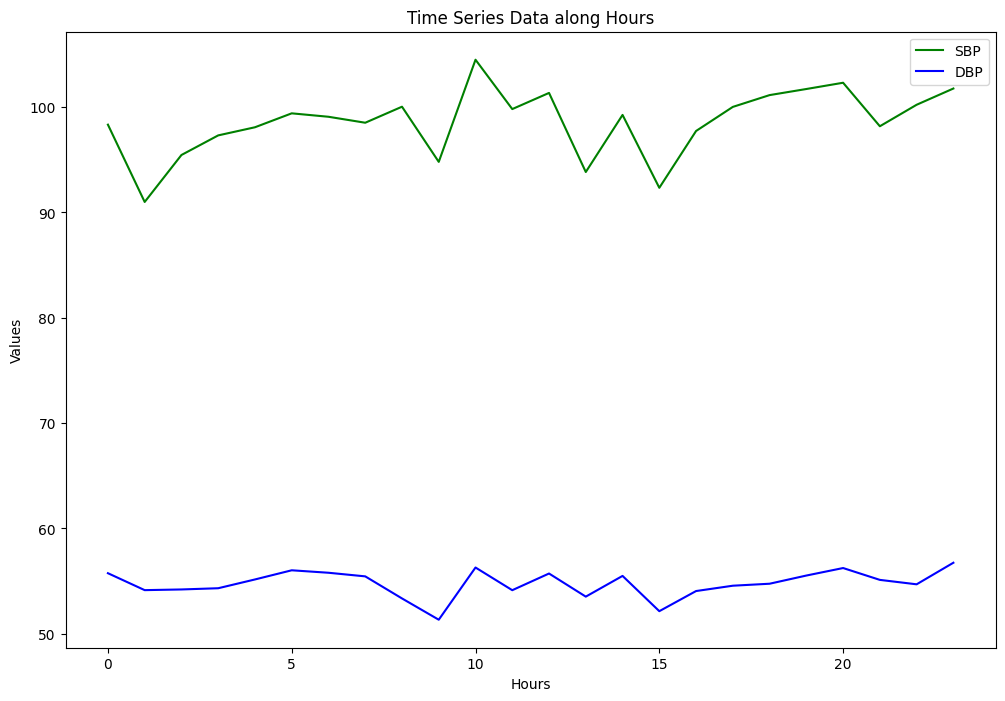

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
data['DateTime'] = pd.to_datetime(data['DateTime'])
data = data.set_index('DateTime')

# Selecting only relevant columns for resampling
data_numeric = data[['SBP', 'DBP']]  # Assuming these are the columns of interest

# Resampling to hourly mean values for numeric columns
data_hourly_mean = data_numeric.resample('H').mean().reset_index()

data_hourly_mean['hour'] = data_hourly_mean['DateTime'].dt.hour

plt.figure(figsize=(12, 8))

# Group by 'hour' and calculate mean for 'SBP' and 'DBP'
hourly_mean = data_hourly_mean.groupby('hour').mean()

plt.plot(hourly_mean.index, hourly_mean['SBP'], color='green', label='SBP')
plt.plot(hourly_mean.index, hourly_mean['DBP'], color='blue', label='DBP')

plt.xlabel('Hours')
plt.ylabel('Values')
plt.title('Time Series Data along Hours')
plt.legend()
plt.show()


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
data['DateTime'] = pd.to_datetime(data['DateTime'])
data['weekday'] = pd.Categorical(data['DateTime'].dt.strftime('%A'),
                                 categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                 ordered=True)

# Group by 'weekday' and calculate mean for 'SBP' and 'DBP'
data_numeric = data[['SBP', 'DBP', 'weekday']]  
daily_mean = data_numeric.groupby('weekday').mean()

plt.figure(figsize=(10, 6))

# Creating bar plots for SBP and DBP
plt.plot(daily_mean.index, daily_mean['SBP'], color='green', alpha=0.7, label='SBP')
plt.plot(daily_mean.index, daily_mean['DBP'], color='blue', alpha=0.7, label='DBP')

plt.xlabel('Days of the Week')
plt.ylabel('Mean Values')
plt.title('Mean SBP and DBP across Days of the Week')
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'DateTime'

## ANOMALY DETECTION

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
# Suppress sklearn warning about scoring failures
warnings.filterwarnings("ignore", message="Scoring failed.*")

# Assuming 'data' is your DataFrame containing columns 'SBP' and 'DBP'

# Define hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': ['auto', 100, 200],
    'contamination': [ 0.03, 0.05, 0.1]
}

# Initialize Isolation Forest
model = IsolationForest(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearch to find the best hyperparameters
grid_search.fit(data[['SBP', 'DBP']])

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Hyperparameters: {'contamination': 0.03, 'max_samples': 'auto', 'n_estimators': 100}


In [ ]:
# Use the best hyperparameters to create the final model
best_model = IsolationForest(**best_params, random_state=42)

# Fit the final model to your data
best_model.fit(data[['SBP', 'DBP']])

IsolationForest(contamination=0.03, random_state=42)

In [28]:
# # Parameters for Isolation Forest
# contamination_value = 0.03
# n_estimators_value = 200  
# max_samples_value = 'auto'  
# max_features_value = 1.0  # (1.0 means considering all features)
# random_state_value = 42  # to ensure reproducibility

# # Initialize Isolation Forest with specified parameters
# model = IsolationForest(
#     n_estimators=n_estimators_value,
#     max_samples=max_samples_value,
#     contamination=contamination_value,
#     max_features=max_features_value,
#     random_state=random_state_value
# )

# Calculate anomaly scores and predictions within a rolling window
window_size = 5
data['score'] = float('nan')  # Initializing the score column


for i in range(len(data)):
    if i >= window_size - 1:
        window_data = data.iloc[i - window_size + 1:i + 1][['SBP', 'DBP']]
        best_model.fit(window_data)
        scores = best_model.decision_function(window_data)
        print(i)
        for j, score in enumerate(scores):
            data.at[data.index[i - window_size + 1 + j], 'score'] = score  # Assign the score to each row in the window

print(data.tail())  # Display the updated DataFrame

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
27

In [29]:
data

,RR,SPO2,MAP,SBP,DBP,HR,PP,CO,class,label,score
DateTime,,,,,,,,,,,
2020-10-18 15:24:00,35.0,99.9,0.0,0.0,0.0,106.9,0.0,0.00,Invalid Measurement,1,-0.034283
2020-10-18 15:25:00,36.4,100.0,87.0,98.9,63.1,107.3,35.8,3841.34,Normal,0,0.040727
2020-10-18 15:26:00,35.2,100.0,75.2,97.9,63.0,107.5,34.9,3751.75,Normal,0,-0.002677
2020-10-18 15:27:00,34.0,100.0,74.8,97.2,62.5,107.0,34.7,3712.90,Normal,0,0.061336
2020-10-18 15:28:00,34.9,100.0,74.0,96.0,62.0,107.0,34.0,3638.00,Normal,0,0.022766
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-24 21:32:00,13.6,94.0,64.4,92.0,51.2,91.6,40.8,3737.28,Normal,0,0.144575
2020-10-24 21:33:00,16.7,93.6,62.8,89.3,50.2,90.7,39.1,3546.37,Normal,0,-0.019715
2020-10-24 21:34:00,12.0,94.3,63.7,91.2,50.6,90.4,40.6,3670.24,Normal,0,0.169293


In [38]:
best_model.fit(data[['SBP', 'DBP']])
data['score'] = best_model.decision_function(data[['SBP', 'DBP']])
data['anomaly_value'] = best_model.predict(data[['SBP', 'DBP']])
data.head()

,RR,SPO2,MAP,SBP,DBP,HR,PP,CO,class,label,score,anomaly_value
DateTime,,,,,,,,,,,,
2020-10-18 15:24:00,35.0,99.9,0.0,0.0,0.0,106.9,0.0,0.00,Invalid Measurement,1,-0.133265,-1
2020-10-18 15:25:00,36.4,100.0,87.0,98.9,63.1,107.3,35.8,3841.34,Normal,0,0.116410,1
2020-10-18 15:26:00,35.2,100.0,75.2,97.9,63.0,107.5,34.9,3751.75,Normal,0,0.120710,1
2020-10-18 15:27:00,34.0,100.0,74.8,97.2,62.5,107.0,34.7,3712.90,Normal,0,0.123578,1
2020-10-18 15:28:00,34.9,100.0,74.0,96.0,62.0,107.0,34.0,3638.00,Normal,0,0.134126,1


anomaly_value
 1    8742
-1     271
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

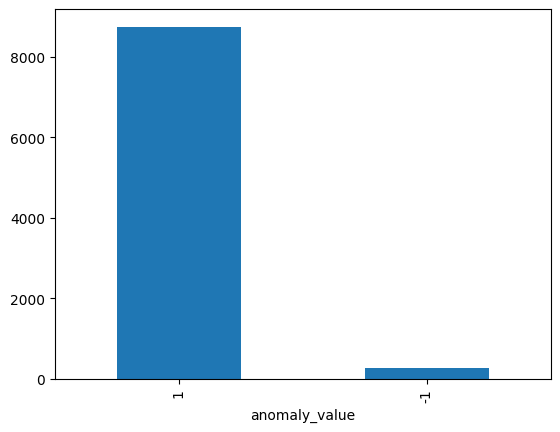

In [39]:
outliers = data.loc[data['anomaly_value'] == -1]
outlier_index = list(outliers.index)

#datapoints classified -1 are anomalous
print(data['anomaly_value'].value_counts())
data['anomaly_value'].value_counts().plot(kind = 'bar')

In [32]:
plt.figure(figsize = (16, 8))

plt.plot(data['DateTime'], data[['SBP']], marker = '.')
# Ensure the length of outliers matches the length of the dates
outlier_dates = outliers['DateTime']
outlier_values = outliers[['SBP']]

# Plot outliers only if they exist
if len(outlier_dates) == len(outlier_values):
    plt.plot(outlier_dates, outlier_values, 'o', color='red', label='Outlier')

plt.title('Anomaly Detection of SBP By Isolation Forest')

#plt.grid()
plt.xlabel('Date')
plt.ylabel('Normal Blood Pressure')
plt.legend()

KeyError: 'DateTime'

<Figure size 1600x800 with 0 Axes>

In [ ]:
plt.figure(figsize = (16, 8))

plt.plot(data['DateTime'], data[['DBP']], marker = '.', color = 'green')
# Ensure the length of outliers matches the length of the dates
outlier_dates = outliers['DateTime']
outlier_values = outliers[['DBP']]

# Plot outliers only if they exist
if len(outlier_dates) == len(outlier_values):
    plt.plot(outlier_dates, outlier_values, 'o', color='red', label='Outlier')

plt.title('Anomaly Detection of DBP By Isolation Forest')

#plt.grid()
plt.xlabel('Date')
plt.ylabel('Normal Blood Pressure')
plt.legend()

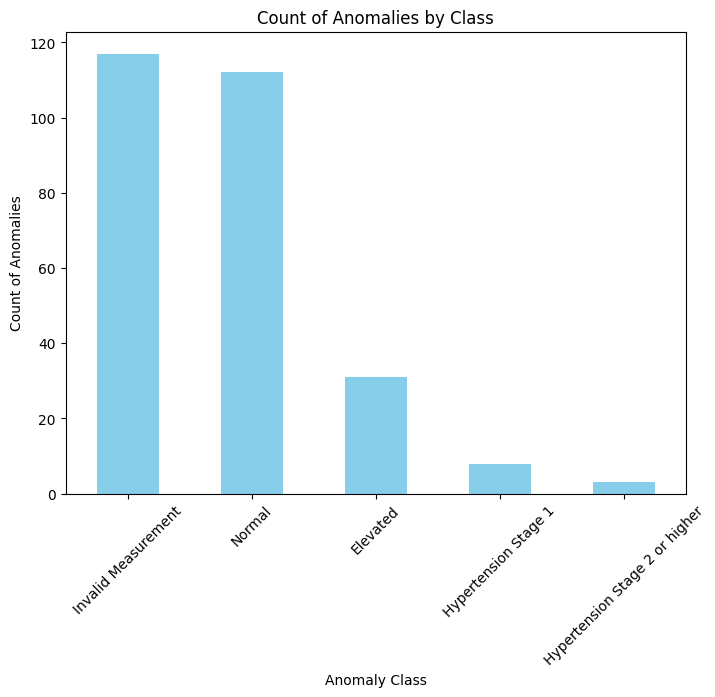

In [40]:
import matplotlib.pyplot as plt

# Assuming 'class' column contains the classes of anomalies
# 'anomaly_value' column indicates whether it's an anomaly or not (1 for anomaly, 0 for normal)

# Filter anomalies from the data
anomalies = data[data['anomaly_value'] == -1]

# Plot histogram of anomaly classes
plt.figure(figsize=(8, 6))
anomalies['class'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Anomaly Class')
plt.ylabel('Count of Anomalies')
plt.title('Count of Anomalies by Class')
plt.xticks(rotation=45)  
plt.show()


In [41]:
data[data['anomaly_value'] == -1].head()

,RR,SPO2,MAP,SBP,DBP,HR,PP,CO,class,label,score,anomaly_value
DateTime,,,,,,,,,,,,
2020-10-18 15:24:00,35.0,99.9,0.0,0.0,0.0,106.9,0.0,0.00,Invalid Measurement,1,-0.133265,-1
2020-10-18 15:49:00,19.8,98.3,57.4,76.9,47.0,102.2,29.9,3055.78,Normal,0,-0.001618,-1
2020-10-18 15:55:00,7.6,98.8,62.3,0.0,0.0,104.2,0.0,0.00,Invalid Measurement,1,-0.133265,-1
2020-10-18 15:56:00,8.9,98.6,52.4,0.0,0.0,103.4,0.0,0.00,Invalid Measurement,1,-0.133265,-1
2020-10-18 16:18:00,0.0,98.8,97.7,0.0,0.0,101.7,0.0,0.00,Invalid Measurement,1,-0.133265,-1


In [42]:
data[data['anomaly_value'] == -1]['class'].value_counts()

class
Invalid Measurement               117
Normal                            112
Elevated                           31
Hypertension Stage 1                8
Hypertension Stage 2 or higher      3
Name: count, dtype: int64

In [36]:
import joblib

# Assuming 'model' is your trained Isolation Forest model

# Save the model to a file
joblib.dump(best_model, 'isolation_forest_model.joblib')

['isolation_forest_model.joblib']

In [43]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score

# Assuming 'data' is your DataFrame with columns 'label' and 'anomaly'
true_labels = data['label']
predicted_labels = data['anomaly_value'].map({-1: 1, 1: 0}) 

# Calculate performance metrics
conf_matrix = confusion_matrix(true_labels, predicted_labels)
classification_rep = classification_report(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, data['score'])  
average_precision = average_precision_score(true_labels, data['score'])  # Replace 'anomaly_score' as above

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_rep)

print(f"\nROC AUC: {roc_auc:.4f}")
print(f"AUC-PR: {average_precision:.4f}")

Confusion Matrix:
[[8678  112]
 [  64  159]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8790
           1       0.59      0.71      0.64       223

    accuracy                           0.98      9013
   macro avg       0.79      0.85      0.82      9013
weighted avg       0.98      0.98      0.98      9013


ROC AUC: 0.0148
AUC-PR: 0.0159
